In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import librosa
import random
import torch 
from torch.utils.data import Dataset , DataLoader
from torch import nn
import torchaudio
import torchvision
from tqdm import tqdm
from timeit import default_timer as timer
device = "cuda"  if torch.cuda.is_available() else "cpu"

In [3]:
device

'cpu'

In [4]:
train_df = pd.read_csv("/kaggle/input/birdclef-2023/train_metadata.csv")
bird_taxonomy = pd.read_csv("/kaggle/input/birdclef-2023/eBird_Taxonomy_v2021.csv")
base_dir = Path("/kaggle/input/birdclef-2023/train_audio")


In [5]:
train_df.loc[200:210 , :]

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
200,afdfly1,"['amesun2', 'combul2']",['call'],-33.6533,26.4083,Muscicapa adusta,African Dusky Flycatcher,Tim Cockcroft,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/320822,afdfly1/XC320822.ogg
201,afdfly1,[],['call'],-33.4833,26.8333,Muscicapa adusta,African Dusky Flycatcher,Tim Cockcroft,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/324019,afdfly1/XC324019.ogg
202,afdfly1,[],['call'],-33.9305,18.7615,Muscicapa adusta,African Dusky Flycatcher,Liana Isabel,Creative Commons Attribution-NonCommercial-Sha...,1.5,https://www.xeno-canto.org/326422,afdfly1/XC326422.ogg
203,afdfly1,[],['song'],-0.6360,34.1170,Muscicapa adusta,African Dusky Flycatcher,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/333785,afdfly1/XC333785.ogg
204,afdfly1,['reftin1'],['song'],-33.5940,26.8969,Muscicapa adusta,African Dusky Flycatcher,Tim Cockcroft,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/342019,afdfly1/XC342019.ogg
205,afdfly1,[],['call'],-1.2780,34.9683,Muscicapa adusta,African Dusky Flycatcher,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/344501,afdfly1/XC344501.ogg
206,afdfly1,[],['song'],-0.3833,37.3112,Muscicapa adusta,African Dusky Flycatcher,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/344763,afdfly1/XC344763.ogg
207,afdfly1,[],"['call', 'song']",3.8104,32.9224,Muscicapa adusta,African Dusky Flycatcher,Josh Engel,Creative Commons Attribution-NonCommercial-Sha...,3.0,https://www.xeno-canto.org/352937,afdfly1/XC352937.ogg
208,afdfly1,[],"['call', 'male']",0.6559,35.5111,Muscicapa adusta,African Dusky Flycatcher,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/396575,afdfly1/XC396575.ogg
209,afdfly1,[],['call'],-33.9838,23.5478,Muscicapa adusta,African Dusky Flycatcher,Dawie de Swardt,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/412147,afdfly1/XC412147.ogg


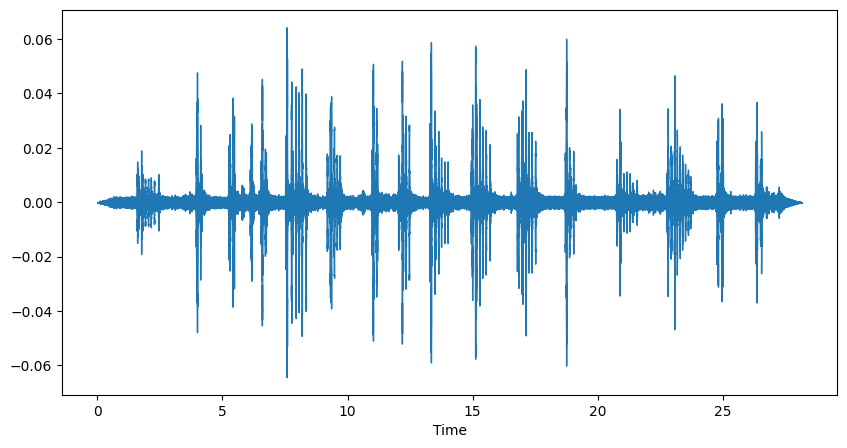

In [6]:
audio , sr = librosa.load("/kaggle/input/birdclef-2023/train_audio/afdfly1/XC115969.ogg" )
plt.figure(figsize = (10,5))
librosa.display.waveshow(y = audio , sr = sr )
plt.show()

In [7]:
# !pip install ffmpeg
# !pip install sox
# import soundfile as sf
# #Loading a random ogg file
# import requests
# request = requests.get("https://upload.wikimedia.org/wikipedia/commons/f/f5/En-us-parrot.ogg")
# with open("parrot.ogg" , "wb") as f:
#     f.write(request.content)

# x, z = t.load("/kaggle/input/audio-file/Bird_singing.ogg")
# print(x , z)


In [8]:
class BirdClef(Dataset):
    def __init__(self, base_dir , df , sampling_rate = 32000 , num_mels = 128 , 
                 min_freq = 128 , max_freq = 16000 , n_fft = 3200 
                 , hop_length = 80 , num_samples  = None )-> None:
        self.base_dir = base_dir
        self.df = df
        self.sr = sampling_rate
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.num_mels = num_mels
        if num_samples != None:
            self.num_samples = num_samples
        else:
            self.num_samples = 5*self.sr
        
        
    def __len__(self):
        return len(self.df)
    
    def resample_audio(self , audio, original_sr, target_sr):
        if target_sr != original_sr:
            resampled_audio = librosa.resample(audio , orig_sr = original_sr , target_sr = target_sr)
            return resampled_audio
        return audio
    
    def right_pad(self , audio):
        audio_len = audio.shape[0]
        if audio_len < self.num_samples:
            num_missing_samples = self.num_samples - audio_len
            last_dim_padding = (0, num_missing_samples)
            audio = np.pad(audio , last_dim_padding)
        return audio
    
    
    def cut_down(self ,audio):
        if audio.shape[0] > self.num_samples:
            audio = audio[:self.num_samples]
        return audio
    
    
    def load_audio(self , index):
        audio , _ = librosa.load(self.base_dir / self.df.loc[index , "filename"] , sr = self.sr )
        audio = self.resample_audio(audio , _ , self.sr)
        audio = self.right_pad(audio)
        audio = self.cut_down(audio)
        return audio , self.sr
    
    def __getclasses__(self):
        classes = sorted(entry.name for entry in os.scandir(self.base_dir) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        class_to_index = {class_name: i for i , class_name in enumerate(classes)}
        self.classes = class_to_index
        return class_to_index
    
    def load_mel_spectrogram(self , index):
        loaded_audio , sr = self.load_audio(index)
        mel_audio = librosa.feature.melspectrogram(y = loaded_audio , sr = sr,
                                                  n_fft = self.n_fft , hop_length = self.hop_length,
                                                  n_mels = self.num_mels , fmin = self.min_freq,
                                                  fmax = self.max_freq)
        mel_audio = librosa.power_to_db(mel_audio ).astype(np.float32)
        return mel_audio
    
    def display_mel_spectrogram(self , index)->None:
        mel_audio = self.load_mel_spectrogram(index)
        librosa.display.specshow(mel_audio , x_axis = "time" , y_axis = "mel")
#         plt.title(f"{self.df.primary_label[index]}", loc = "center")
        plt.xticks([])
        plt.yticks([])
        plt.show()
    
    
    def mix_down(self , audio):
        pass
            
        
    
    def torchaudio_getitem(self , index):
        audio  = torchaudio.load(self.base_dir / self.df.filename[index])
        audio_mel = torchaudio.transforms.MelSpectrogram(y = audio , sr = self.sr,
                                                  n_fft = self.n_fft , hop_length = self.hop_length,
                                                  n_mels = self.num_mels , fmin = self.min_freq,
                                                  fmax = self.max_freq)
        audio_mel_tensor = audio_mel(audio_mel)
        return audio_mel_tensor
        
        
    def __getitem__(self , index):
        classes = self.__getclasses__()
        mel_audio = self.load_mel_spectrogram(index)
        label = self.df.primary_label[index]
        mel_audio_tensor = torch.from_numpy(mel_audio)
        img = torch.stack([mel_audio_tensor  , mel_audio_tensor , mel_audio_tensor])
        return img , self.classes[label]
        

In [9]:
torch.manual_seed(12)
data = BirdClef(base_dir , train_df)
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data , test_data = torch.utils.data.random_split(dataset = data ,lengths = [ train_size , test_size])
len(train_data) , len(test_data) , len(data)

(13552, 3389, 16941)

In [10]:
data[0]

(tensor([[[-22.9094, -21.3622, -20.0343,  ..., -25.4774, -25.4968, -25.5598],
          [-23.5806, -22.1964, -21.0286,  ..., -24.8975, -25.0391, -25.2518],
          [-23.8328, -22.2978, -20.9674,  ..., -28.6176, -28.8445, -29.0889],
          ...,
          [-41.6050, -39.5544, -37.6782,  ..., -23.8992, -24.2300, -24.6451],
          [-46.9301, -45.0321, -43.2835,  ..., -30.3952, -30.7967, -31.2899],
          [-48.8235, -48.8235, -48.8235,  ..., -48.8235, -48.8235, -48.8235]],
 
         [[-22.9094, -21.3622, -20.0343,  ..., -25.4774, -25.4968, -25.5598],
          [-23.5806, -22.1964, -21.0286,  ..., -24.8975, -25.0391, -25.2518],
          [-23.8328, -22.2978, -20.9674,  ..., -28.6176, -28.8445, -29.0889],
          ...,
          [-41.6050, -39.5544, -37.6782,  ..., -23.8992, -24.2300, -24.6451],
          [-46.9301, -45.0321, -43.2835,  ..., -30.3952, -30.7967, -31.2899],
          [-48.8235, -48.8235, -48.8235,  ..., -48.8235, -48.8235, -48.8235]],
 
         [[-22.9094, -21.362

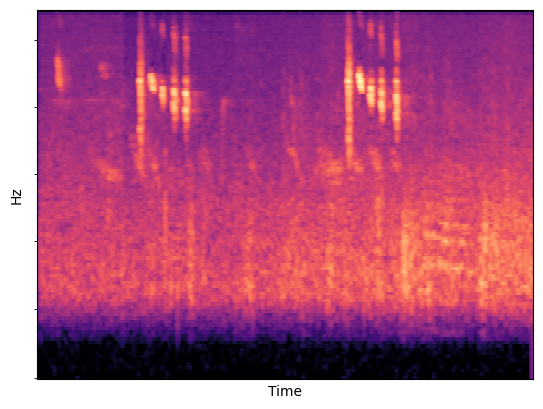

In [34]:

data.display_mel_spectrogram(205)


In [35]:
data.__getclasses__()

{'abethr1': 0,
 'abhori1': 1,
 'abythr1': 2,
 'afbfly1': 3,
 'afdfly1': 4,
 'afecuc1': 5,
 'affeag1': 6,
 'afgfly1': 7,
 'afghor1': 8,
 'afmdov1': 9,
 'afpfly1': 10,
 'afpkin1': 11,
 'afpwag1': 12,
 'afrgos1': 13,
 'afrgrp1': 14,
 'afrjac1': 15,
 'afrthr1': 16,
 'amesun2': 17,
 'augbuz1': 18,
 'bagwea1': 19,
 'barswa': 20,
 'bawhor2': 21,
 'bawman1': 22,
 'bcbeat1': 23,
 'beasun2': 24,
 'bkctch1': 25,
 'bkfruw1': 26,
 'blacra1': 27,
 'blacuc1': 28,
 'blakit1': 29,
 'blaplo1': 30,
 'blbpuf2': 31,
 'blcapa2': 32,
 'blfbus1': 33,
 'blhgon1': 34,
 'blhher1': 35,
 'blksaw1': 36,
 'blnmou1': 37,
 'blnwea1': 38,
 'bltapa1': 39,
 'bltbar1': 40,
 'bltori1': 41,
 'blwlap1': 42,
 'brcale1': 43,
 'brcsta1': 44,
 'brctch1': 45,
 'brcwea1': 46,
 'brican1': 47,
 'brobab1': 48,
 'broman1': 49,
 'brosun1': 50,
 'brrwhe3': 51,
 'brtcha1': 52,
 'brubru1': 53,
 'brwwar1': 54,
 'bswdov1': 55,
 'btweye2': 56,
 'bubwar2': 57,
 'butapa1': 58,
 'cabgre1': 59,
 'carcha1': 60,
 'carwoo1': 61,
 'categr': 62,
 'cc

In [36]:
data[12301][0].shape

torch.Size([128, 2001])

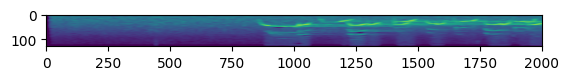

In [38]:
import matplotlib.pyplot as plt
plt.imshow(data[11265][0].permute(1,2,0).numpy())

In [16]:
train_dataloader = DataLoader(dataset = train_data , batch_size = 128 , shuffle = True , num_workers = 0)
test_dataloader = DataLoader(dataset = test_data , batch_size = 128 , shuffle = False , num_workers =0)


In [11]:
next(iter(test_dataloader))[0].shape

torch.Size([128, 3, 128, 2001])

In [12]:
import timm
model = timm.create_model('efficientnet_b0.ra_in1k', pretrained=True)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [1]:
class BirdClefModel(nn.Module):
    def __init__(self , output_size = 264):
        super().__init__()
        self.model = timm.create_model('efficientnet_b0.ra_in1k', pretrained=True)
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.classifier = nn.Sequential(nn.Dropout(p = 0.2 , inplace = True)
            ,nn.Linear(in_features = 1280 , out_features = output_size , bias = True))
        
        
    def forward(self , x):
        return self.model(x)
model = BirdClefModel().to(device)
from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), 
        
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

model.conv_stem

NameError: name 'nn' is not defined

In [12]:
next(model.parameters()).is_cuda

True

In [15]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    model.eval() 
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
    
            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
from tqdm.auto import tqdm

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.1194 | train_acc: 0.1840 | test_loss: 4.0941 | test_acc: 0.1762
Epoch: 2 | train_loss: 3.7211 | train_acc: 0.2246 | test_loss: 3.9256 | test_acc: 0.2032
Epoch: 3 | train_loss: 3.4655 | train_acc: 0.2604 | test_loss: 3.8035 | test_acc: 0.2250


In [16]:
model_0_results

{'train_loss': [4.119446426067713, 3.7211213584216134, 3.4654618524155527],
 'train_acc': [0.18404649595687333, 0.22455146563342318, 0.26044474393531],
 'test_loss': [4.094138030652647, 3.9255725189491555, 3.803531602576927],
 'test_acc': [0.17623899514268368, 0.20323409987856708, 0.22496394960534302]}

In [14]:
import requests
inp_model = Path("inp_model")
request = requests.get("https://github.com/u-r-a-bot/Bird_clef_audio_proc/raw/main/prediction/model_effnet_b0_model.pth")
inp_model.mkdir(parents = True , exist_ok = True)
with open(inp_model / "effnet-B0.pth" , "wb") as f:
    f.write(request.content)
model = torch.load(inp_model / "effnet-B0.pth")


In [15]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()


        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)


    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):

    model.eval() 
    

    test_loss, test_acc = 0, 0
    

    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)
    

            test_pred_logits = model(X)


            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc
from tqdm.auto import tqdm


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    

    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
model_0_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.3266 | train_acc: 0.2829 | test_loss: 3.7532 | test_acc: 0.2292
Epoch: 2 | train_loss: 3.1009 | train_acc: 0.3186 | test_loss: 3.6794 | test_acc: 0.2389
Epoch: 3 | train_loss: 2.9523 | train_acc: 0.3436 | test_loss: 3.6358 | test_acc: 0.2507


In [ ]:
model_path = Path("Model")
def model_save_script(model):
    model = model.to("cpu")
    model_path.mkdir(parents = True  , exist_ok  = True)
    model_save_path = model_path / "model_effnet_b0_script.pth"
    model_scripted = torch.jit.script(model)
    model_scripted.save(model_save_path)
    
    
def model_save_state_dict(model):
    model = model.to("cpu")
    model_path.mkdir(parents = True  , exist_ok  = True)
    model_save_path = model_path / "model_effnet_b0_state_dict.pth"
    torch.save(obj = model , f = model_save_path)

In [6]:
target_labels = [
        'abethr1', 'abhori1', 'abythr1', 'afbfly1', 'afdfly1', 'afecuc1',
        'affeag1', 'afgfly1', 'afghor1', 'afmdov1', 'afpfly1', 'afpkin1',
        'afpwag1', 'afrgos1', 'afrgrp1', 'afrjac1', 'afrthr1', 'amesun2',
        'augbuz1', 'bagwea1', 'barswa', 'bawhor2', 'bawman1', 'bcbeat1',
        'beasun2', 'bkctch1', 'bkfruw1', 'blacra1', 'blacuc1', 'blakit1',
        'blaplo1', 'blbpuf2', 'blcapa2', 'blfbus1', 'blhgon1', 'blhher1',
        'blksaw1', 'blnmou1', 'blnwea1', 'bltapa1', 'bltbar1', 'bltori1',
        'blwlap1', 'brcale1', 'brcsta1', 'brctch1', 'brcwea1', 'brican1',
        'brobab1', 'broman1', 'brosun1', 'brrwhe3', 'brtcha1', 'brubru1',
        'brwwar1', 'bswdov1', 'btweye2', 'bubwar2', 'butapa1', 'cabgre1',
        'carcha1', 'carwoo1', 'categr', 'ccbeat1', 'chespa1', 'chewea1',
        'chibat1', 'chtapa3', 'chucis1', 'cibwar1', 'cohmar1', 'colsun2',
        'combul2', 'combuz1', 'comsan', 'crefra2', 'crheag1', 'crohor1',
        'darbar1', 'darter3', 'didcuc1', 'dotbar1', 'dutdov1', 'easmog1',
        'eaywag1', 'edcsun3', 'egygoo', 'equaka1', 'eswdov1', 'eubeat1',
        'fatrav1', 'fatwid1', 'fislov1', 'fotdro5', 'gabgos2', 'gargan',
        'gbesta1', 'gnbcam2', 'gnhsun1', 'gobbun1', 'gobsta5', 'gobwea1',
        'golher1', 'grbcam1', 'grccra1', 'grecor', 'greegr', 'grewoo2',
        'grwpyt1', 'gryapa1', 'grywrw1', 'gybfis1', 'gycwar3', 'gyhbus1',
        'gyhkin1', 'gyhneg1', 'gyhspa1', 'gytbar1', 'hadibi1', 'hamerk1',
        'hartur1', 'helgui', 'hipbab1', 'hoopoe', 'huncis1', 'hunsun2',
        'joygre1', 'kerspa2', 'klacuc1', 'kvbsun1', 'laudov1', 'lawgol',
        'lesmaw1', 'lessts1', 'libeat1', 'litegr', 'litswi1', 'litwea1',
        'loceag1', 'lotcor1', 'lotlap1', 'luebus1', 'mabeat1', 'macshr1',
        'malkin1', 'marsto1', 'marsun2', 'mcptit1', 'meypar1', 'moccha1',
        'mouwag1', 'ndcsun2', 'nobfly1', 'norbro1', 'norcro1', 'norfis1',
        'norpuf1', 'nubwoo1', 'pabspa1', 'palfly2', 'palpri1', 'piecro1',
        'piekin1', 'pitwhy', 'purgre2', 'pygbat1', 'quailf1', 'ratcis1',
        'raybar1', 'rbsrob1', 'rebfir2', 'rebhor1', 'reboxp1', 'reccor',
        'reccuc1', 'reedov1', 'refbar2', 'refcro1', 'reftin1', 'refwar2',
        'rehblu1', 'rehwea1', 'reisee2', 'rerswa1', 'rewsta1', 'rindov',
        'rocmar2', 'rostur1', 'ruegls1', 'rufcha2', 'sacibi2', 'sccsun2',
        'scrcha1', 'scthon1', 'shesta1', 'sichor1', 'sincis1', 'slbgre1',
        'slcbou1', 'sltnig1', 'sobfly1', 'somgre1', 'somtit4', 'soucit1',
        'soufis1', 'spemou2', 'spepig1', 'spewea1', 'spfbar1', 'spfwea1',
        'spmthr1', 'spwlap1', 'squher1', 'strher', 'strsee1', 'stusta1',
        'subbus1', 'supsta1', 'tacsun1', 'tafpri1', 'tamdov1', 'thrnig1',
        'trobou1', 'varsun2', 'vibsta2', 'vilwea1', 'vimwea1', 'walsta1',
        'wbgbir1', 'wbrcha2', 'wbswea1', 'wfbeat1', 'whbcan1', 'whbcou1',
        'whbcro2', 'whbtit5', 'whbwea1', 'whbwhe3', 'whcpri2', 'whctur2',
        'wheslf1', 'whhsaw1', 'whihel1', 'whrshr1', 'witswa1', 'wlwwar',
        'wookin1', 'woosan', 'wtbeat1', 'yebapa1', 'yebbar1', 'yebduc1',
        'yebere1', 'yebgre1', 'yebsto1', 'yeccan1', 'yefcan', 'yelbis1',
        'yenspu1', 'yertin1', 'yesbar1', 'yespet1', 'yetgre1', 'yewgre1'
        ]

primary_label                                                 abethr1
secondary_labels                                                   []
type                                                         ['song']
latitude                                                       4.3906
longitude                                                     38.2788
scientific_name                                    Turdus tephronotus
common_name                                  African Bare-eyed Thrush
author                                                  Rolf A. de By
license             Creative Commons Attribution-NonCommercial-Sha...
rating                                                            4.0
url                                 https://www.xeno-canto.org/128013
filename                                         abethr1/XC128013.ogg
Name: 0, dtype: object

In [19]:
specie_to_name = {}
for i in target_labels:
    index = train_df.loc[(train_df["primary_label"] == i)].index[0]
    specie_to_name[i] = train_df.loc[index , "common_name"] 
specie_to_name

{'abethr1': 'African Bare-eyed Thrush',
 'abhori1': 'African Black-headed Oriole',
 'abythr1': 'Abyssinian Thrush',
 'afbfly1': 'African Blue Flycatcher',
 'afdfly1': 'African Dusky Flycatcher',
 'afecuc1': 'African Emerald Cuckoo',
 'affeag1': 'African Fish-Eagle',
 'afgfly1': 'African Gray Flycatcher',
 'afghor1': 'African Gray Hornbill',
 'afmdov1': 'Mourning Collared-Dove',
 'afpfly1': 'African Paradise-Flycatcher',
 'afpkin1': 'African Pygmy Kingfisher',
 'afpwag1': 'African Pied Wagtail',
 'afrgos1': 'African Goshawk',
 'afrgrp1': 'African Green-Pigeon',
 'afrjac1': 'African Jacana',
 'afrthr1': 'African Thrush',
 'amesun2': 'Amethyst Sunbird',
 'augbuz1': 'Augur Buzzard',
 'bagwea1': 'Baglafecht Weaver',
 'barswa': 'Barn Swallow',
 'bawhor2': 'Black-and-white-casqued Hornbill',
 'bawman1': 'Black-and-white Mannikin',
 'bcbeat1': 'Blue-cheeked Bee-eater',
 'beasun2': 'Beautiful Sunbird',
 'bkctch1': 'Black-crowned Tchagra',
 'bkfruw1': 'Black-faced Rufous-Warbler',
 'blacra1': 'B

In [17]:
torch.save(obj = model , f = model_path / "model_effnet_b0_model.pth")